In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import optimizers
import cv2
from itertools import chain
import glob
from google.colab import files

In [ ]:
kernel = np.ones((5,5),np.uint8)

In [ ]:
pathTrain = r'/content/drive/My Drive/Major_Project/fingers/train/*'
pathTest = r'/content/drive/My Drive/Major_Project/fingers/test/*'
NUMBER_OF_CLASSES = 6
BATCH_SIZE = 64
# EPOCHS = 10
EPOCHS = 10
#indice_to_label = {0:"0L", 1:"1L", 2:"2L", 3:"3L", 4:"4L", 5:"5L", 6:"0R", 7:"1R", 8:"2R", 9:"3R", 10:"4R", 11:"5R"}
indice_to_label = {0:"0", 1:"1", 2:"2", 3:"3", 4:"4", 5:"5"}
label_to_indice = {v:k for k,v in indice_to_label.items()}

In [ ]:
def process_image(img,kernel):
    img = cv2.resize(img, (128, 128))
    img = cv2.GaussianBlur(img,(5,5),0)
    _,img = cv2.threshold(img,80,255,cv2.THRESH_BINARY)
    
    im_floodfill = img.copy()
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    img = img | im_floodfill_inv
    
    
    img = img/255
    return img

def img_to_sample(img, kernel = None):
    img = img.astype(np.uint8)
    img = np.reshape(img, (128, 128))
    
    img = process_image(img, kernel)
    
    img = np.reshape(img, (128, 128, 1))
    return img

In [ ]:
train_set = [(file[-6] ,img_to_sample(cv2.imread(file, 0))) for file in glob.glob(pathTrain)]
test_set = [(file[-6] ,img_to_sample(cv2.imread(file, 0))) for file in glob.glob(pathTest)]

In [ ]:
# X_Train = [t[1] for t in train_set]
# X_Train = X_Train[0:500]
# Y_Train = [label_to_indice[t[0]] for t in train_set]
# Y_Train = Y_Train[0:500]

# X_Test = [t[1] for t in test_set]
# X_Test = X_Test
# Y_Test = [label_to_indice[t[0]] for t in test_set]
# Y_Test = Y_Test

# X_Train = np.array(X_Train)
# Y_Train = to_categorical(Y_Train, num_classes = NUMBER_OF_CLASSES)
# X_Test = np.array(X_Test)
# Y_Test = to_categorical(Y_Test, num_classes = NUMBER_OF_CLASSES)

In [ ]:
X_Train = [t[1] for t in train_set]
X_Train = X_Train + X_Train[0:6000]
Y_Train = [label_to_indice[t[0]] for t in train_set]
Y_Train = Y_Train + Y_Train[0:6000]

X_Test = [t[1] for t in test_set]
X_Test = X_Test
Y_Test = [label_to_indice[t[0]] for t in test_set]
Y_Test = Y_Test

X_Train = np.array(X_Train)
Y_Train = to_categorical(Y_Train, num_classes = NUMBER_OF_CLASSES)
X_Test = np.array(X_Test)
Y_Test = to_categorical(Y_Test, num_classes = NUMBER_OF_CLASSES)

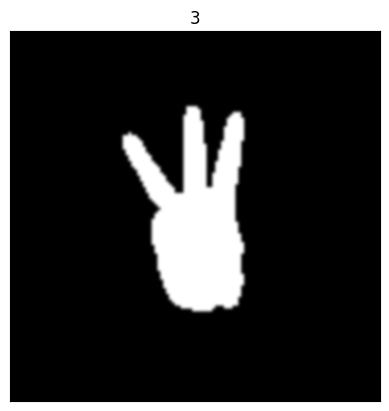

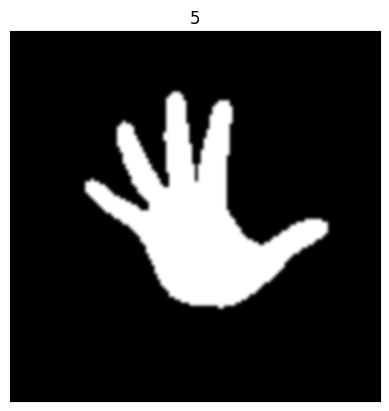

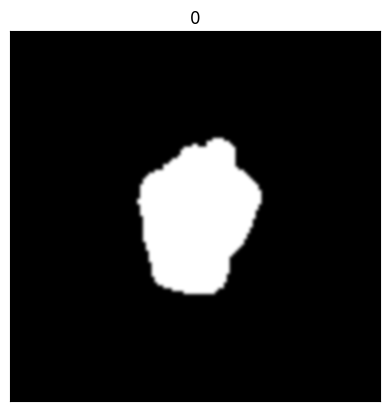

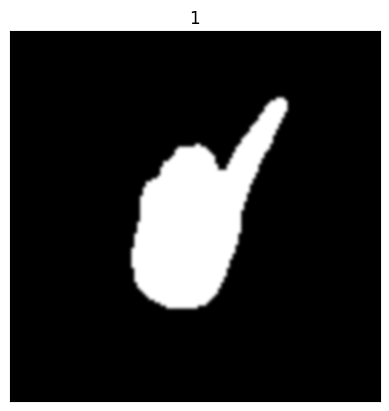

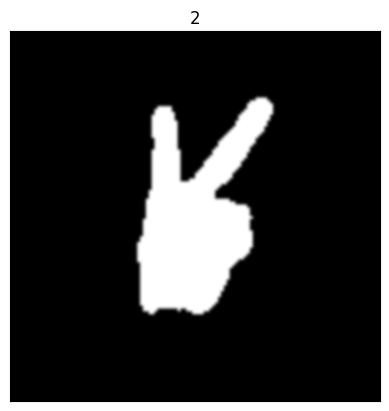

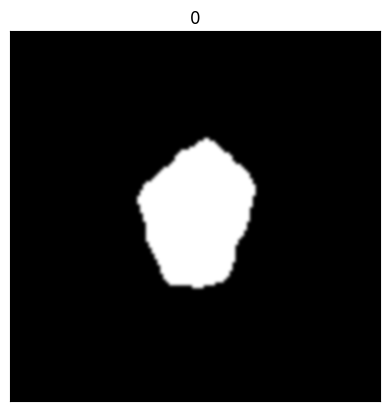

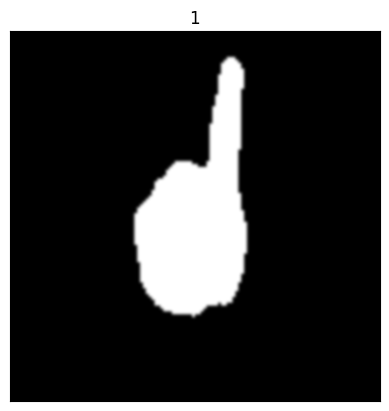

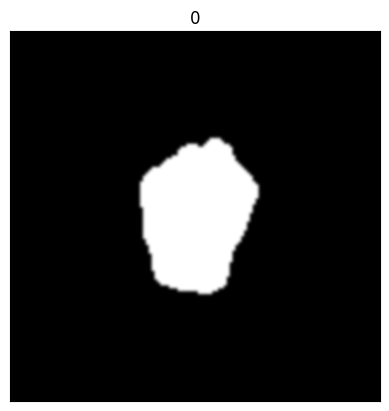

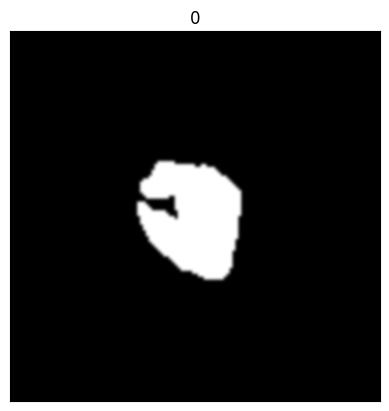

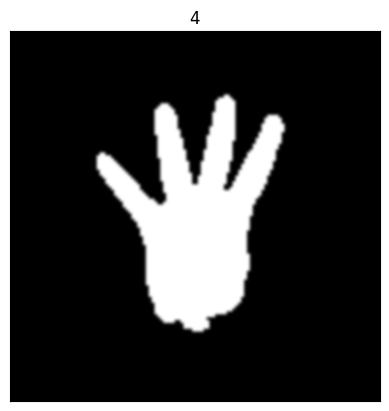

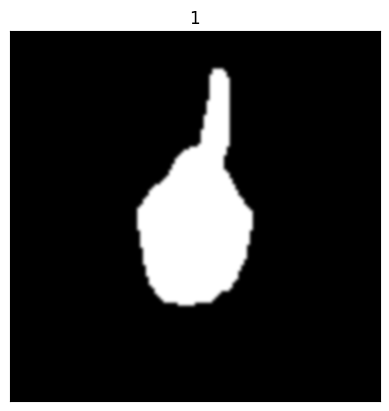

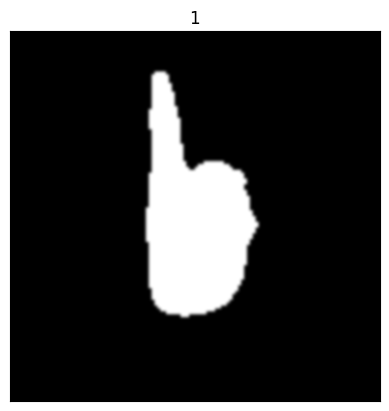

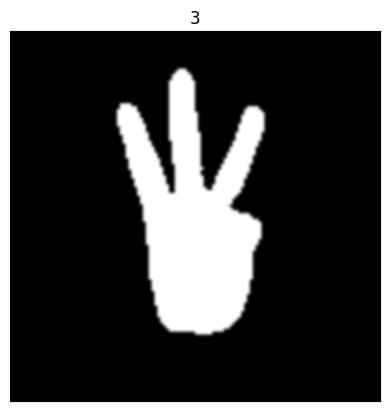

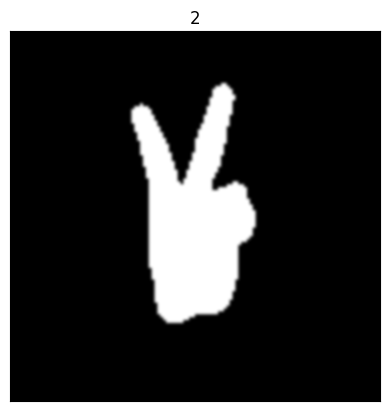

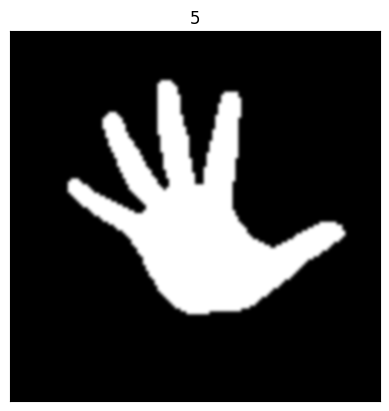

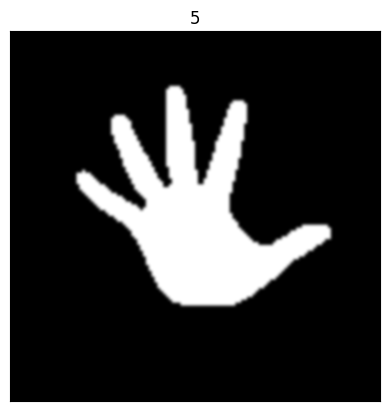

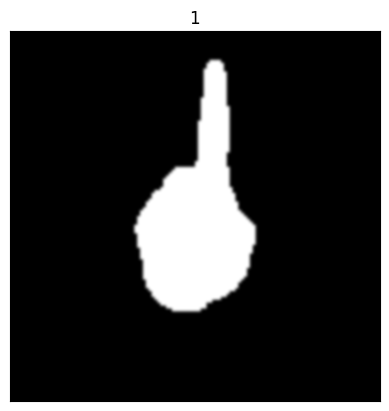

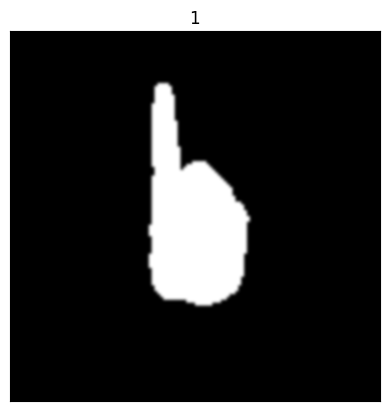

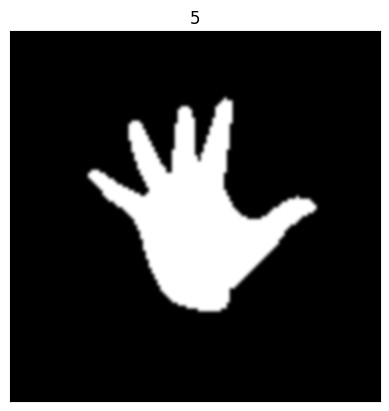

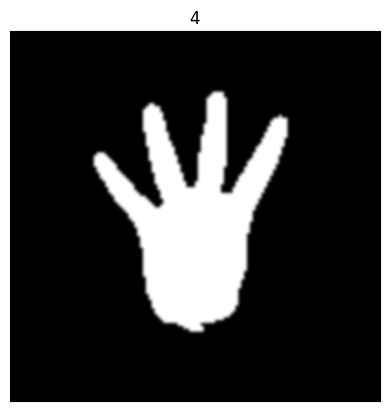

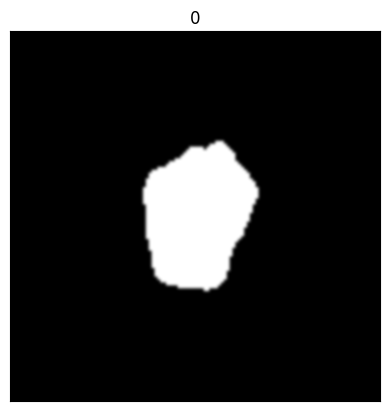

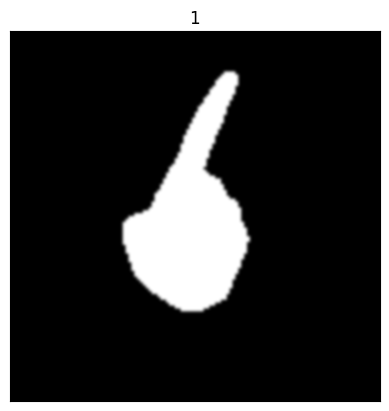

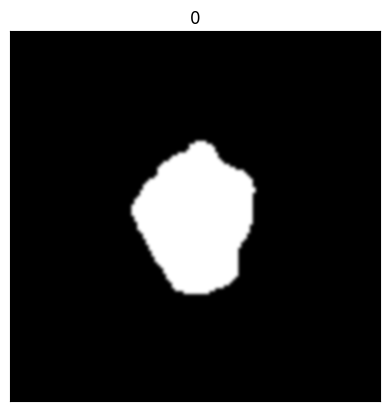

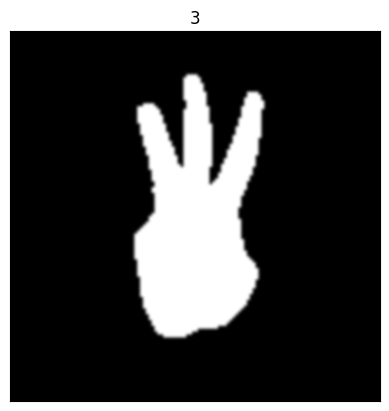

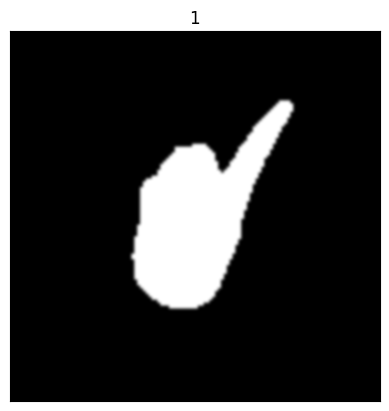

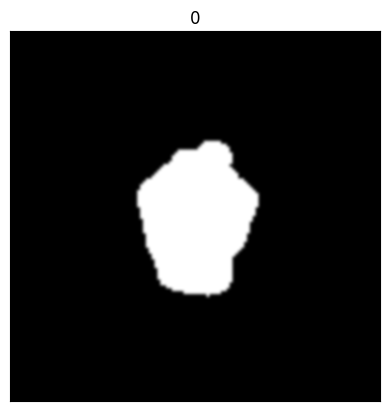

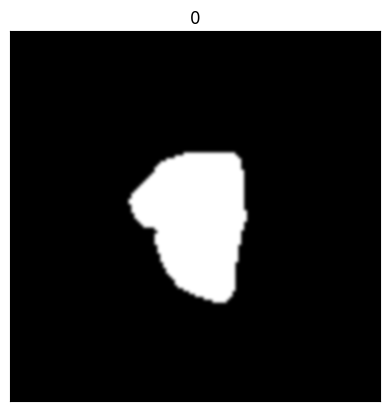

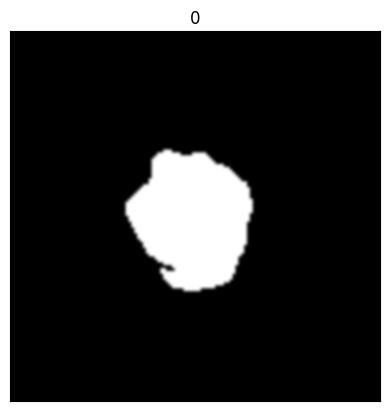

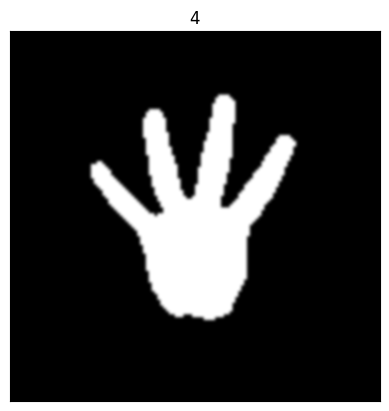

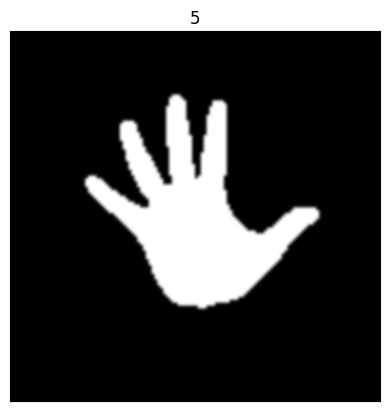

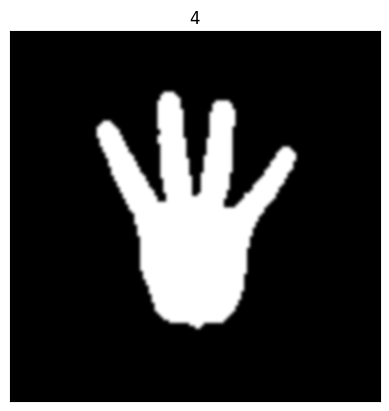

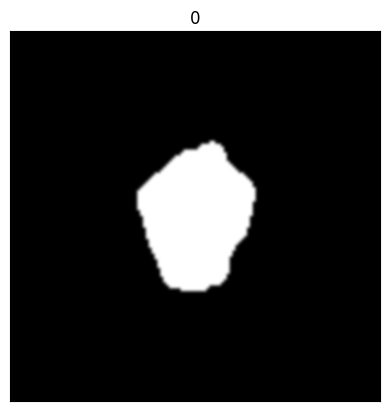

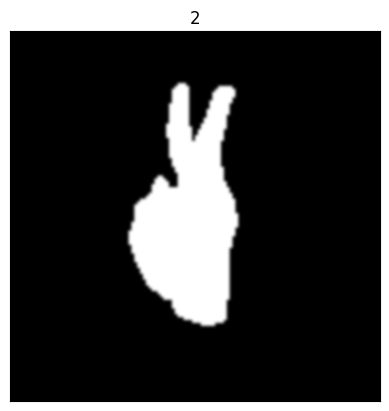

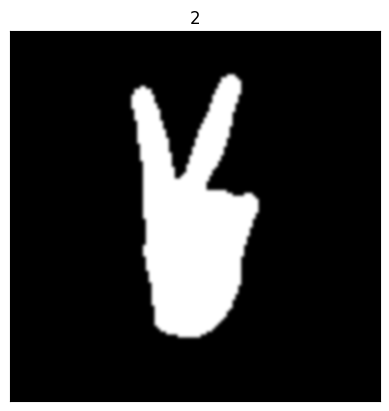

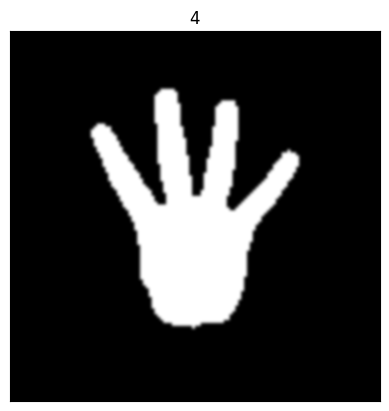

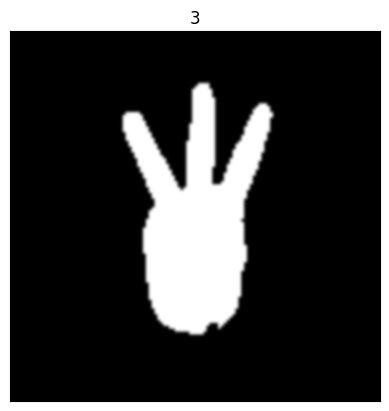

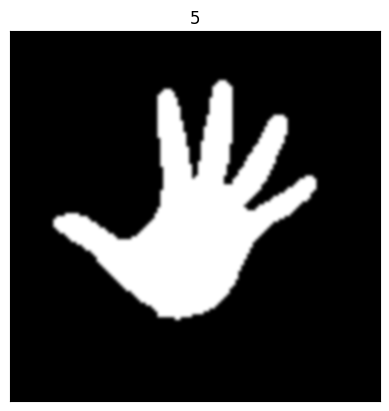

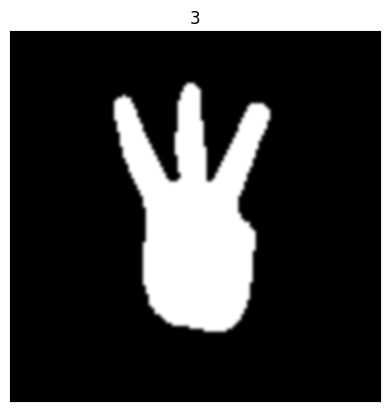

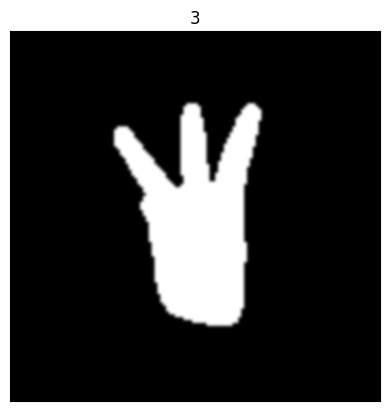

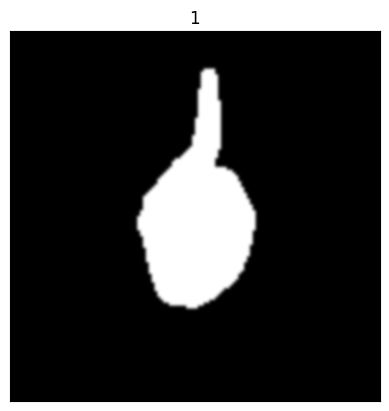

In [ ]:
for i in range(20):
    plt.imshow(X_Train[i,:].reshape((128, 128)), cmap='gray', interpolation='bicubic')
    plt.title(indice_to_label[np.argmax(Y_Train[i])])
    plt.xticks([]), plt.yticks([])
    plt.show()
    
for i in range(20):
    plt.imshow(X_Test[i,:].reshape((128, 128)), cmap='gray', interpolation='bicubic')
    plt.title(indice_to_label[np.argmax(Y_Test[i])])
    plt.xticks([]), plt.yticks([])
    plt.show()

15052- Train <br>
3620- Test

In [ ]:
print(X_Train.shape)
print(Y_Train.shape)

print(X_Test.shape)
print(Y_Test.shape)

(15052, 128, 128, 1)
(15052, 6)
(3620, 128, 128, 1)
(3620, 6)


In [ ]:
aug = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range = 0.1,
    horizontal_flip=False,
    fill_mode="nearest")

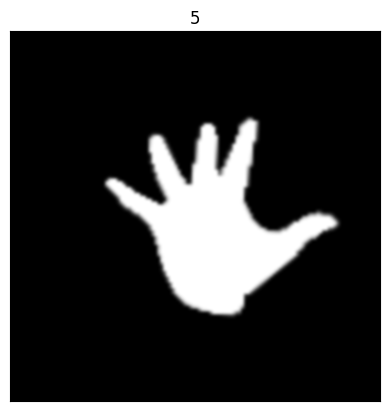

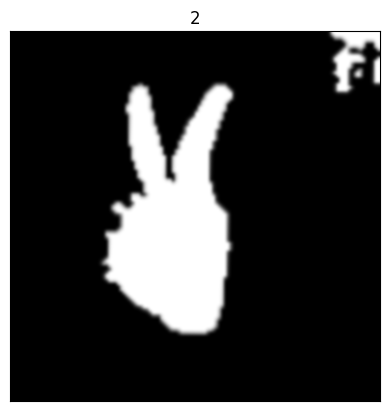

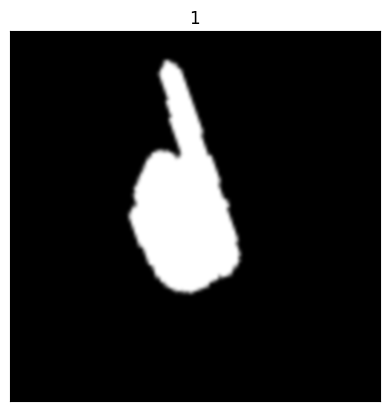

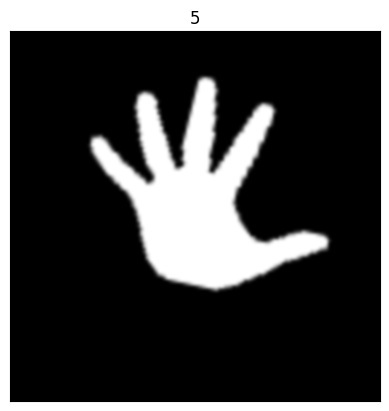

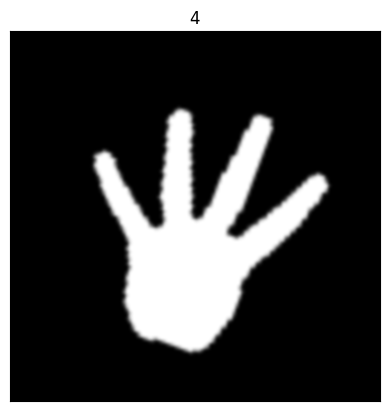

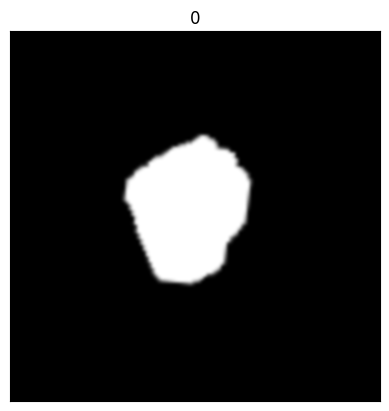

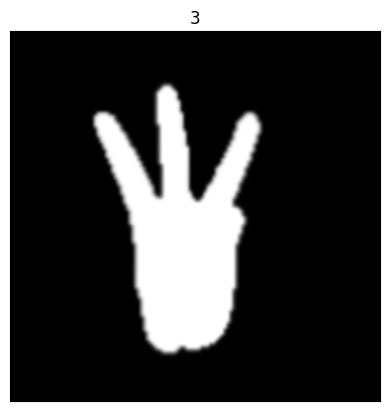

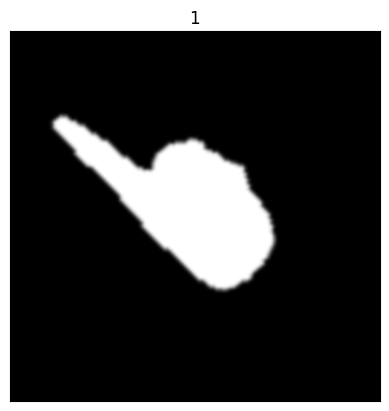

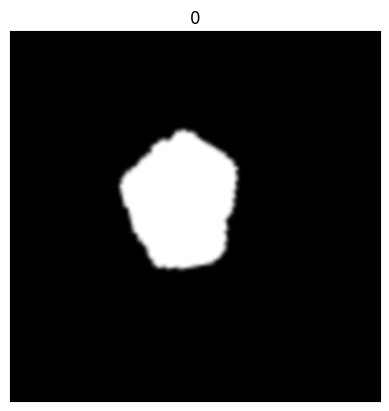

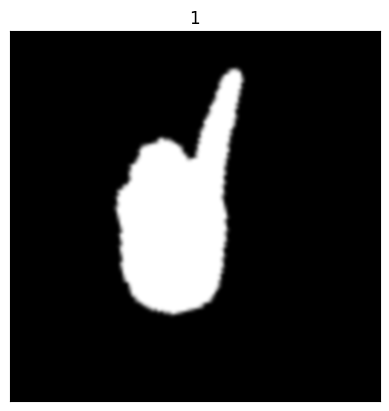

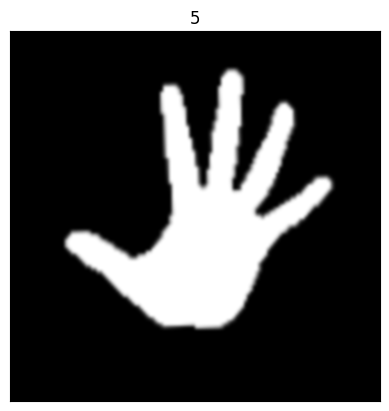

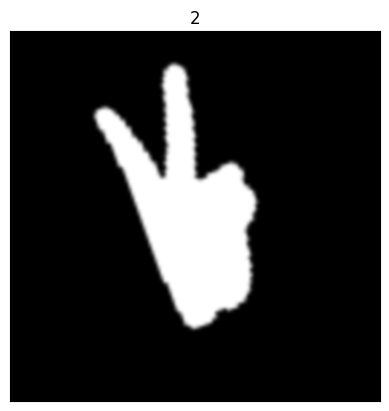

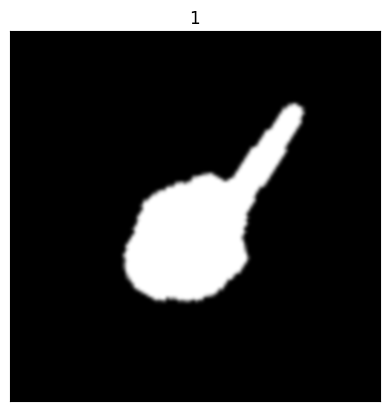

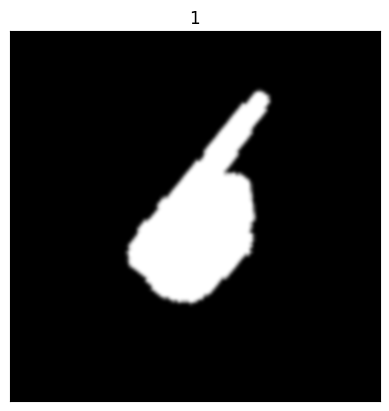

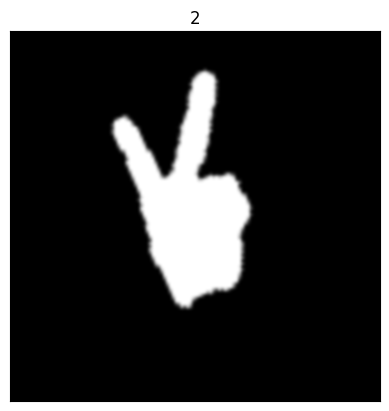

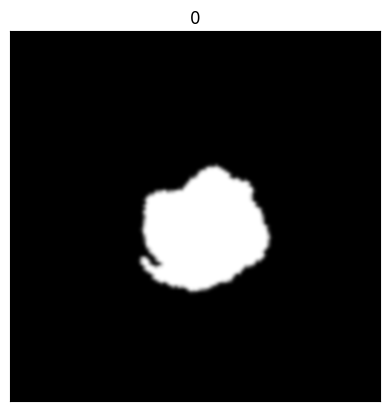

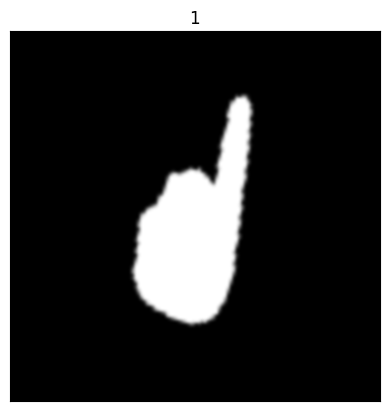

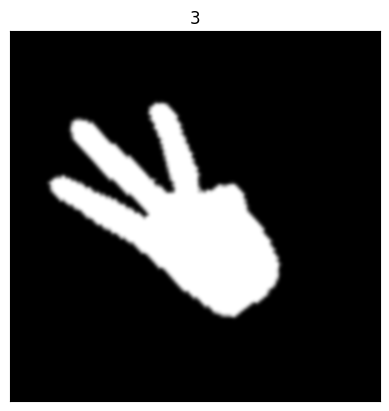

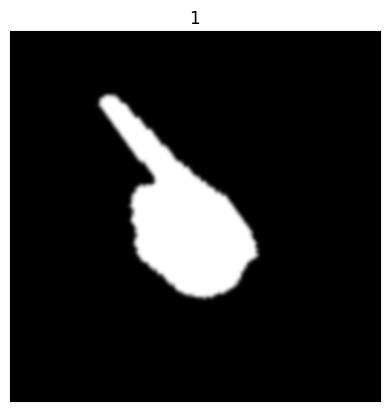

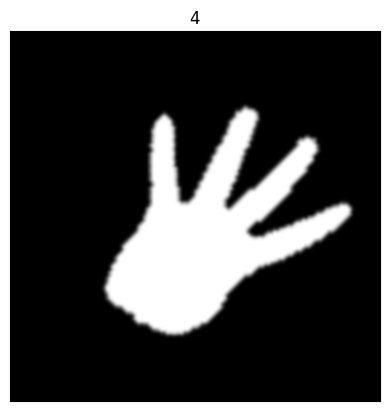

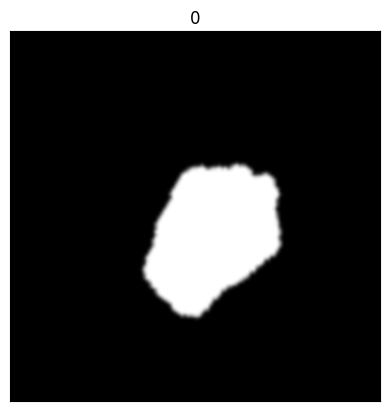

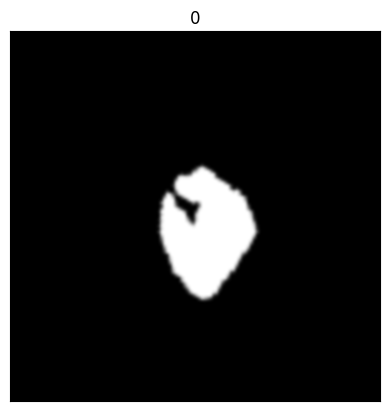

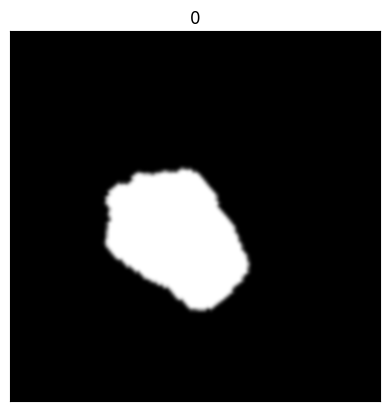

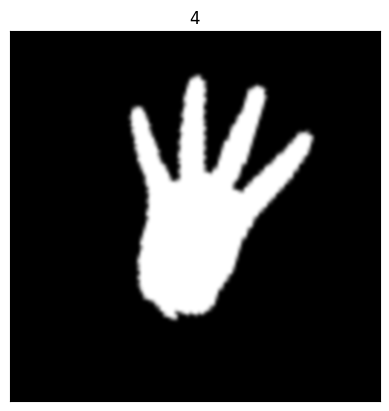

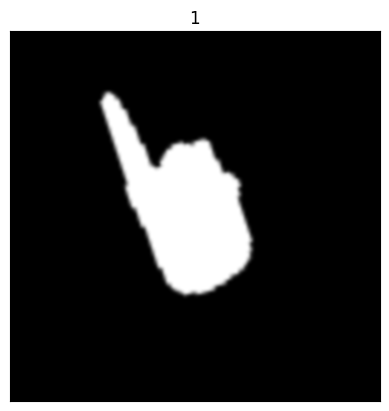

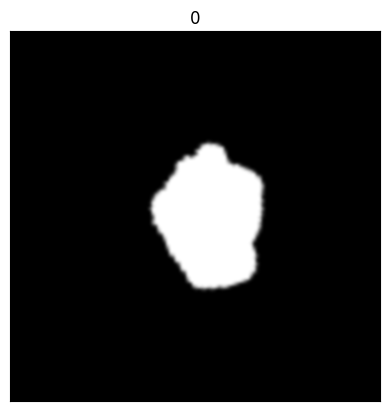

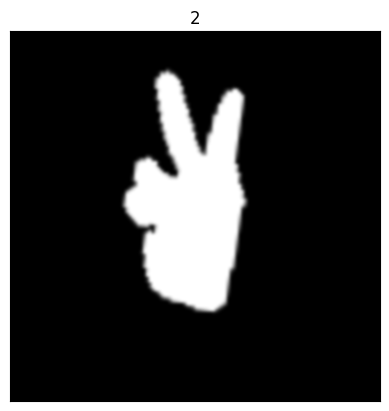

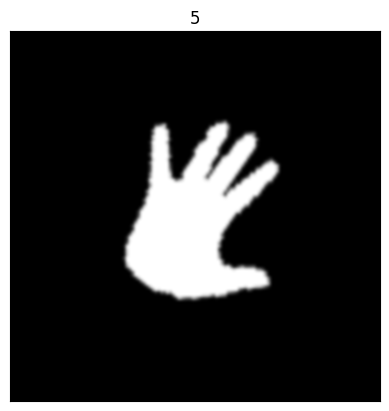

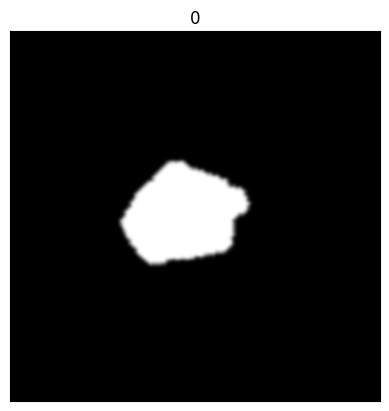

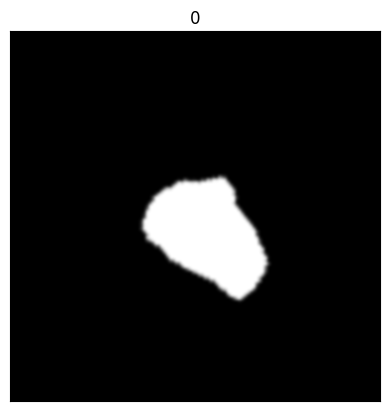

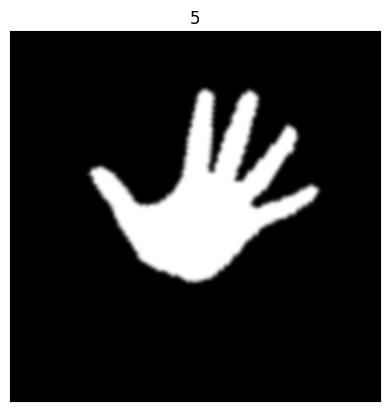

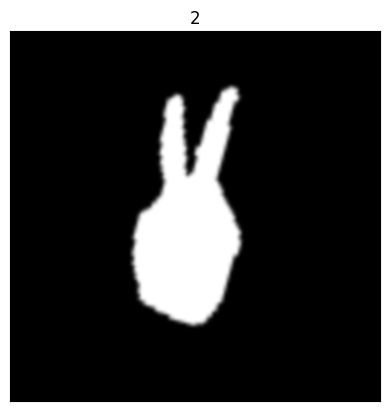

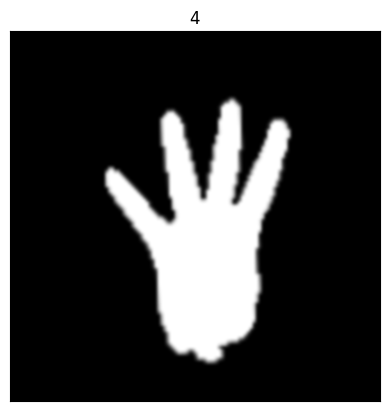

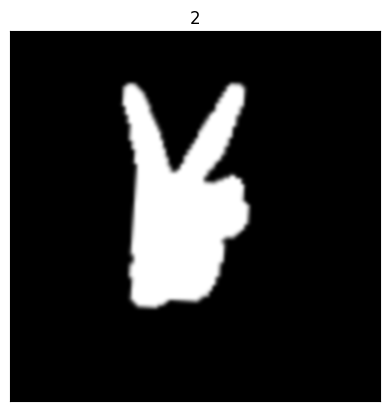

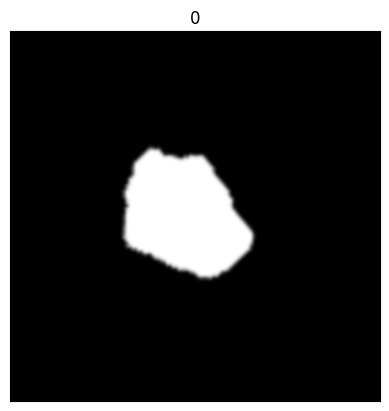

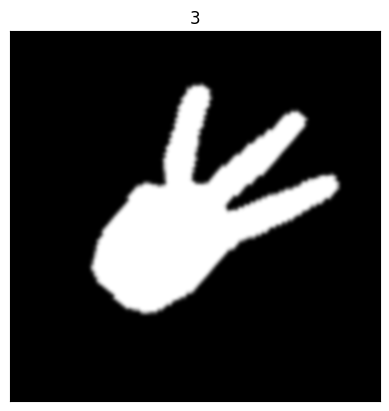

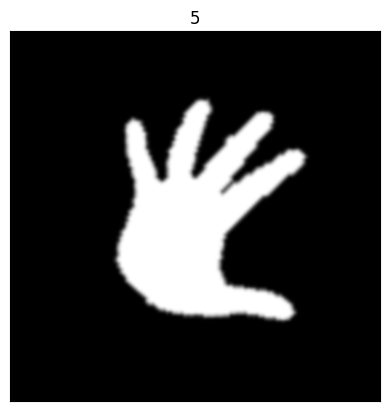

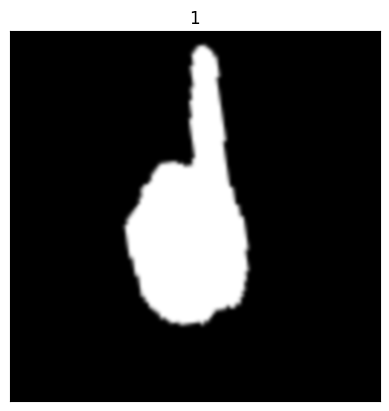

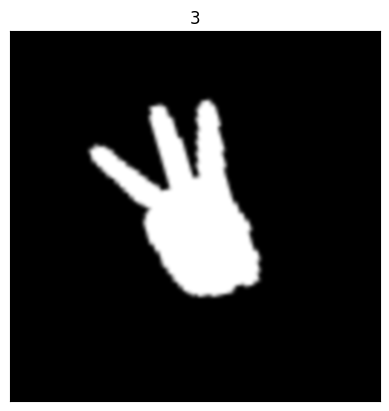

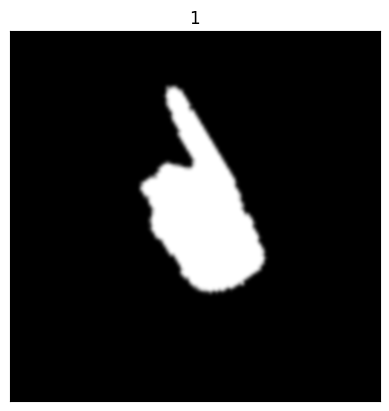

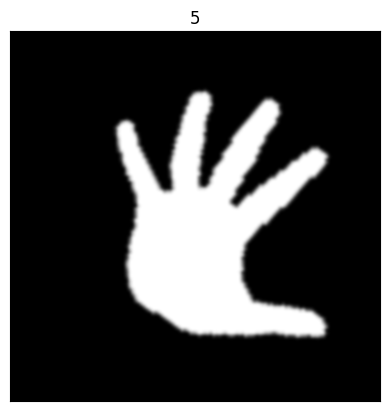

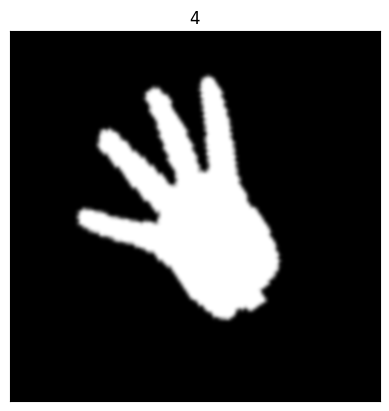

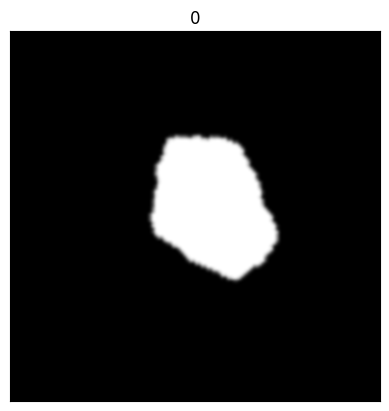

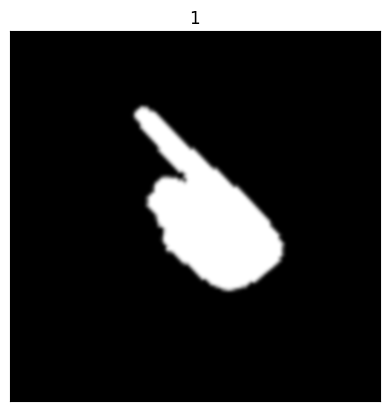

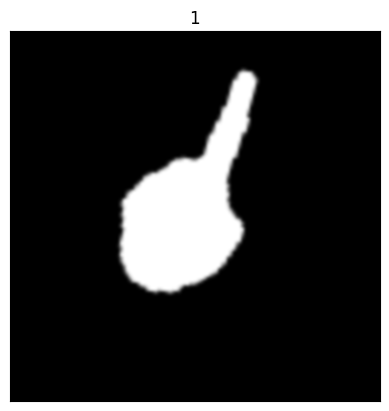

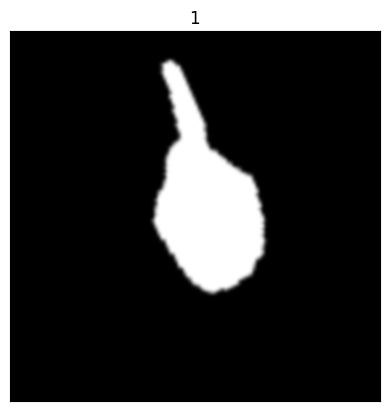

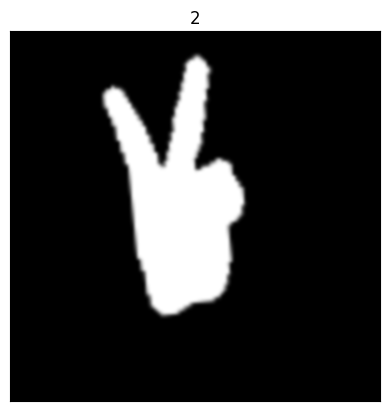

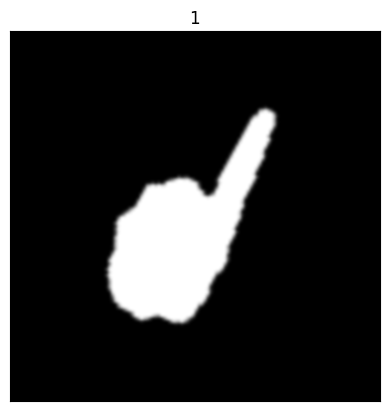

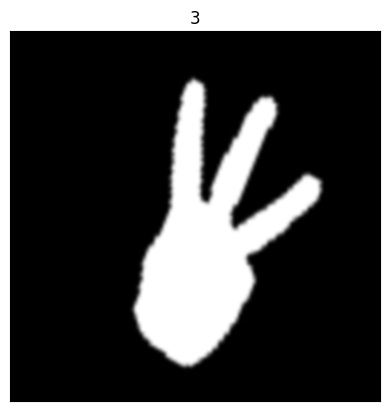

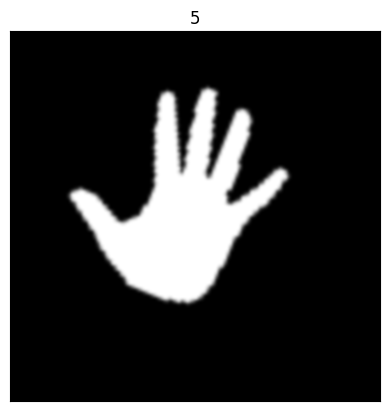

In [ ]:
batches = 0
x_sample = X_Train[0:50]
y_sample = Y_Train[0:50]
batch = 1
for x_batch, y_batch in aug.flow(x_sample, y_sample, batch_size=batch):
        plt.imshow(x_batch[0,:].reshape((128, 128)), cmap='gray', interpolation='bicubic')
        plt.title(indice_to_label[np.argmax(y_batch[0])])
        plt.xticks([]), plt.yticks([])
        plt.show()
        batches += 1
        if batches >= len(x_sample) // batch:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

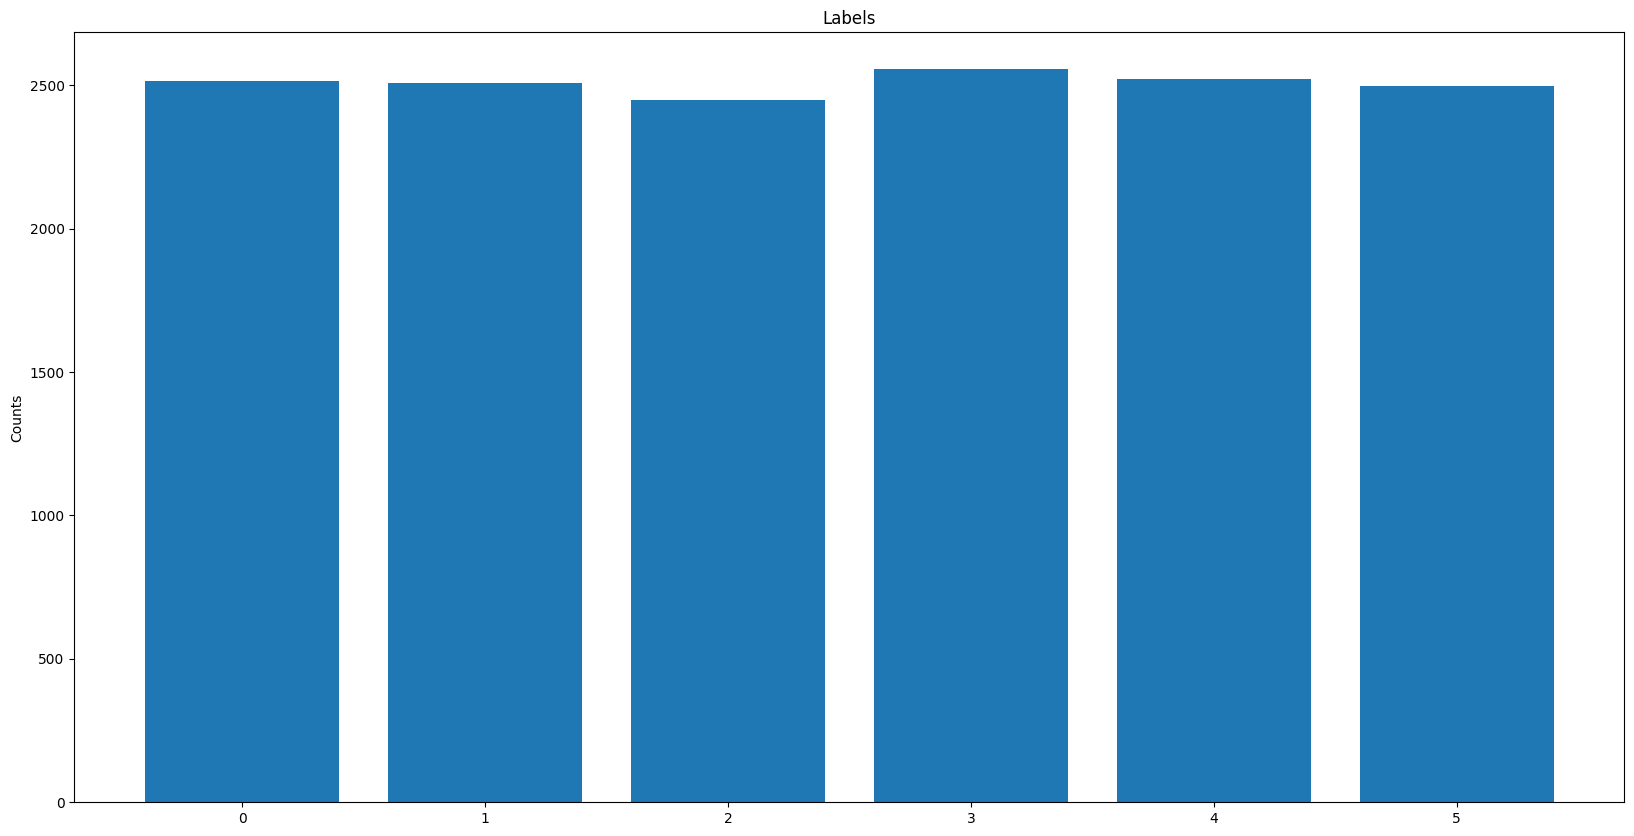

In [ ]:
counts = Counter([x.argmax() for x in Y_Train])
plt.subplots(figsize = (20,10))
values = [k for k in counts.values()]
labels = [k for k in counts.keys()]
plt.bar(labels, values, align='center')
plt.ylabel('Counts')
plt.title('Labels')

plt.show()

In [ ]:
def HandModel(input_shape):
    
    X_input = Input(input_shape, name = "input_layer")
    
    X = Conv2D(64, (3, 3), strides = (1, 1), activation='relu')(X_input)
    X = BatchNormalization()(X)
    
    X = Conv2D(64, (3, 3), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(64, (5, 5), strides = (2, 2), padding="same", activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.2)(X)
    
    X = Conv2D(128, (3, 3), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(128, (3, 3), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(128, (5, 5), strides = (2, 2), padding="same", activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.3)(X)

    X = Flatten()(X)
    
    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.4)(X)
    
    X = Dense(NUMBER_OF_CLASSES, activation='softmax', name='output_layer')(X)

    model = Model(inputs = X_input, outputs = X, name='HandModel')

    return model

In [ ]:
model = HandModel(X_Train.shape[1:])

In [ ]:
model.summary()

Model: "HandModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        10

In [ ]:
sgd = optimizers.SGD(lr=0.01, nesterov=True)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics = ["accuracy"])

with open('/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_architecture.json', 'w') as f:
    f.write(model.to_json())
    
#filename = "handmodel_fingers_weights.hdf5"
filename=r'/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5'
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', verbose=1, factor=0.5, patience=1, min_lr=0.0001, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0, restore_best_weights = True, patience=3, mode='min')
callbacks_list = [checkpoint, earlyStopping, reduce_lr]

In [ ]:
history = model.fit_generator(generator = aug.flow(X_Train, Y_Train, batch_size=BATCH_SIZE), 
                              steps_per_epoch= X_Train.shape[0] // BATCH_SIZE, 
                              validation_data=aug.flow(X_Test, Y_Test, batch_size=BATCH_SIZE),
                              validation_steps = X_Test.shape[0] // BATCH_SIZE, 
                              epochs = EPOCHS, 
                              callbacks=callbacks_list)

<ipython-input-19-07f56ad9ff34>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = aug.flow(X_Train, Y_Train, batch_size=BATCH_SIZE),


Epoch 1/10
235/235 [==============================] - ETA: 0s - loss: 0.4351 - accuracy: 0.8491
Epoch 1: loss improved from inf to 0.43508, saving model to /content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5
235/235 [==============================] - 96s 357ms/step - loss: 0.4351 - accuracy: 0.8491 - val_loss: 3.7310 - val_accuracy: 0.1660 - lr: 0.0100
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.9695
Epoch 2: loss improved from 0.43508 to 0.10947, saving model to /content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5
235/235 [==============================] - 91s 385ms/step - loss: 0.1095 - accuracy: 0.9695 - val_loss: 2.5729 - val_accuracy: 0.3892 - lr: 0.0100
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9805
Epoch 3: loss improved from 0.10947 to 0.07115, saving model to /content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_

In [ ]:
# history = model.fit(x = X_Train, y = Y_Train, validation_data=(X_Test, Y_Test), batch_size = BATCH_SIZE, epochs = EPOCHS, callbacks=callbacks_list)

In [ ]:
ev = model.evaluate(X_Test, Y_Test)

print("Loss : ",ev[0])
print("Accuracy : {} %".format(ev[1]*100))

ev

114/114 [==============================] - 5s 37ms/step - loss: 0.0501 - accuracy: 0.9959
Loss :  0.05005224421620369
Accuracy : 99.58563446998596 %


[0.05005224421620369, 0.9958563446998596]

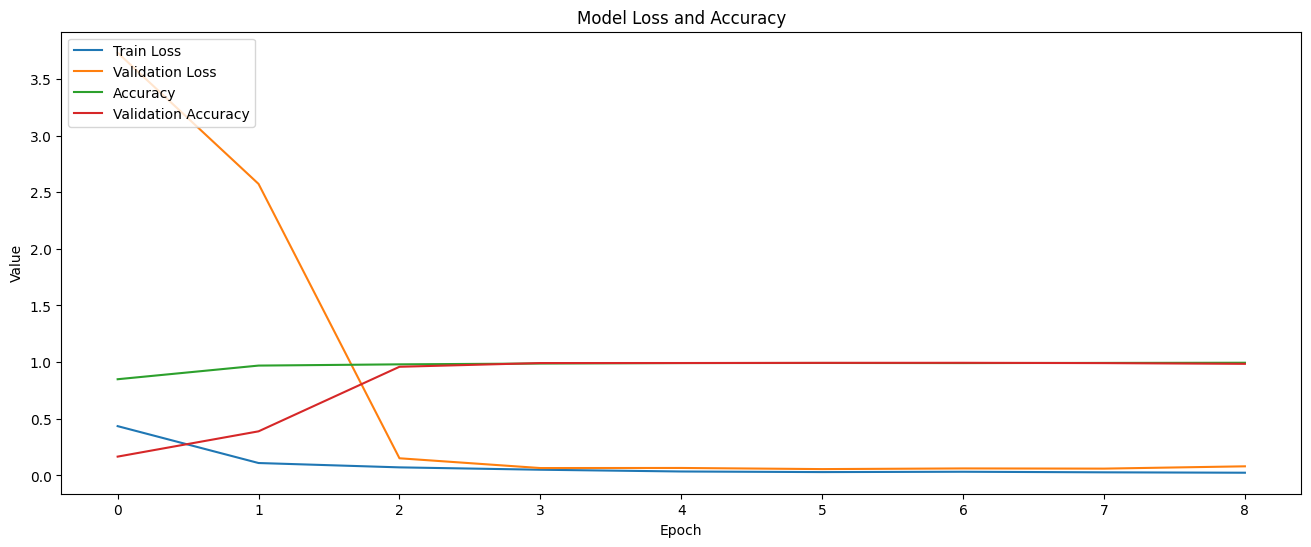

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss', "Accuracy", "Validation Accuracy"], loc='upper left')
plt.savefig(r'/content/drive/MyDrive/Major_Project/fingers/model2/training.png')
plt.show()

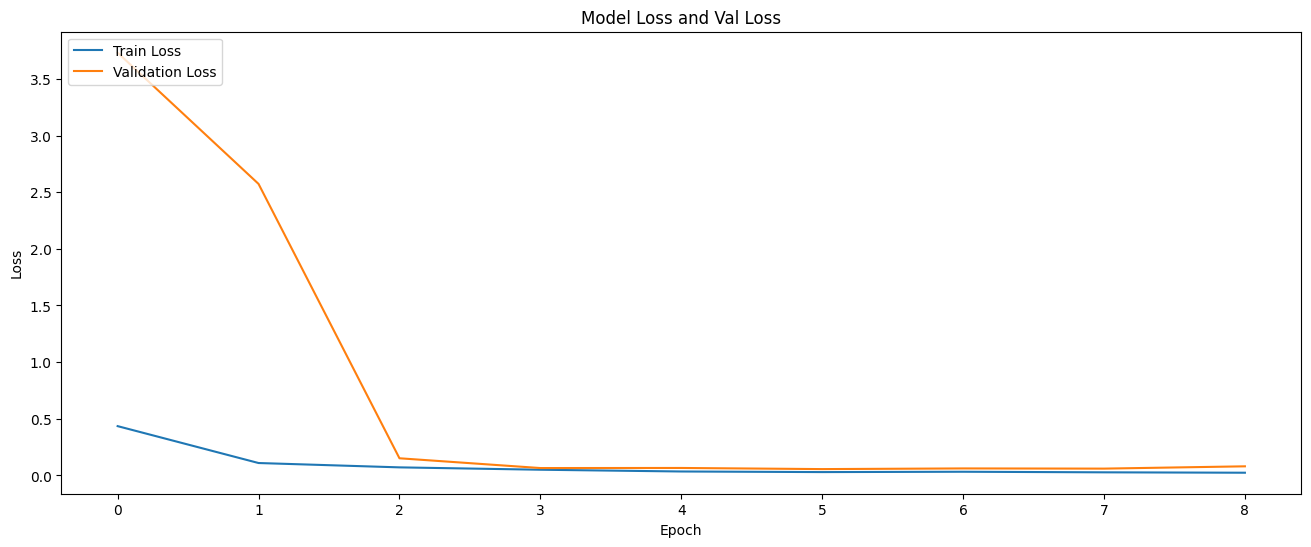

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss and Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
plt.savefig(r'/content/drive/MyDrive/Major_Project/fingers/model2/trainingloss.png')
plt.show()

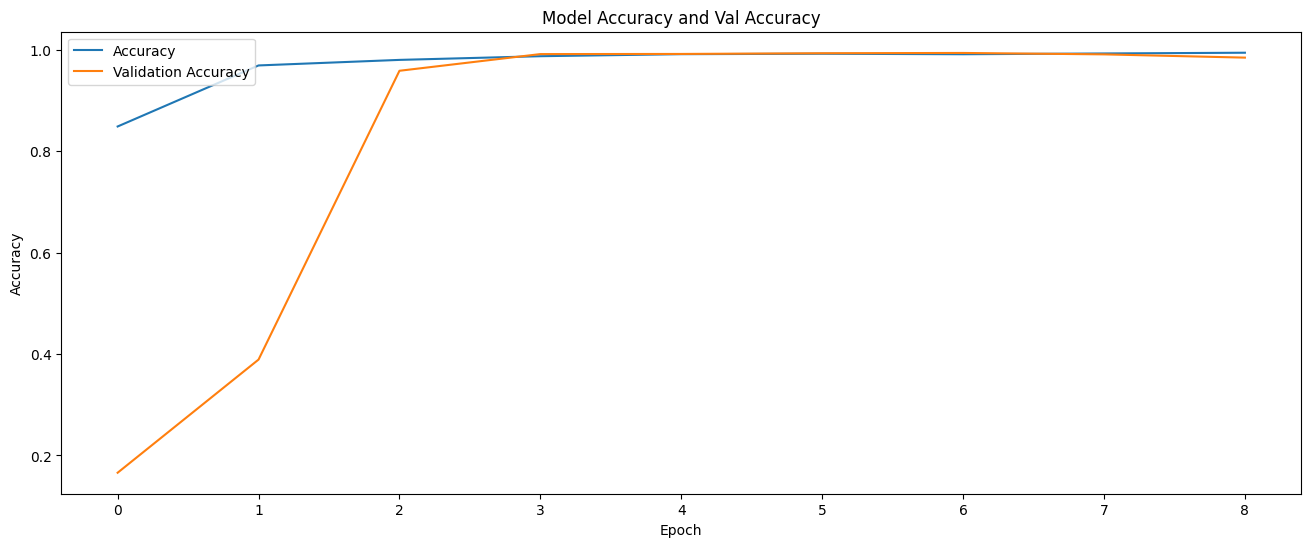

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy and Val Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Accuracy", "Validation Accuracy"], loc='upper left')
plt.savefig(r'/content/drive/MyDrive/Major_Project/fingers/model2/trainingacc.png')
plt.show()

In [ ]:
model.save(r'/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5')

In [ ]:
preds = model.predict(X_Test)
preds = (preds > 0.5).astype(int)

114/114 [==============================] - 4s 34ms/step


In [ ]:
y_preds = [l.index(1) if 1 in l else 0 for l in preds.tolist()]
y_true = [l.index(1) for l in Y_Test.tolist()]

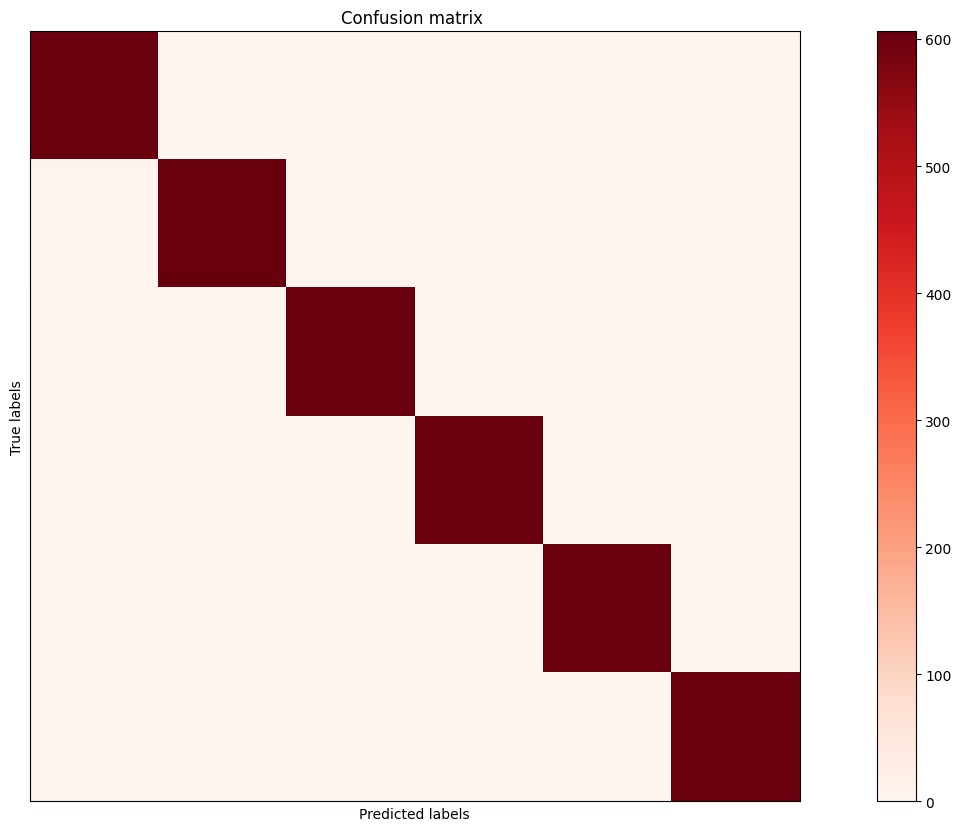

In [ ]:
cm = confusion_matrix(y_true, y_preds)

plt.subplots(figsize=(20, 10))
plt.imshow(cm, cmap=plt.cm.Reds)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.savefig(r'/content/drive/MyDrive/Major_Project/fingers/model2/testingCM.png', bbox_inches='tight')
plt.show()

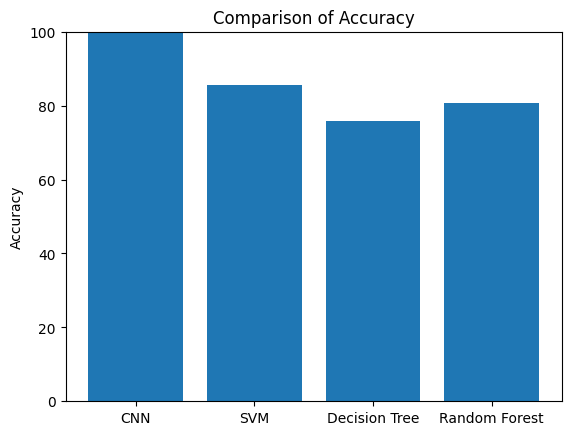

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the accuracy values for each model
cnn_accuracy = 99.58
svm_accuracy = 85.56
dt_accuracy = 75.94
rf_accuracy = 80.72

# Create a bar chart
models = ['CNN', 'SVM', 'Decision Tree', 'Random Forest']
accuracy = [cnn_accuracy, svm_accuracy, dt_accuracy, rf_accuracy]
plt.bar(models, accuracy)
plt.ylim(0, 100)
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')
plt.savefig(r'/content/drive/MyDrive/Major_Project/fingers/model2/comparison_accu.png')
# Show the plot
plt.show()

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow
# Load the trained model
model = load_model('/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5')

# Define the function to preprocess the image before feeding it to the model
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    img = img.reshape(1, 128, 128, 1)
    img = img.astype('float32')
    img /= 255
    return img

# Define the function to predict the floor number based on the image
def predict_floor_number(img):
    img = preprocess_image(img)
    pred = model.predict(img)
    floor_number = np.argmax(pred)
    return floor_number

# Open the video file
cap = cv2.VideoCapture('/content/drive/MyDrive/Major_Project/fingers/model2/demo.mp4')

while True:
    # Read a frame from the video file
    ret, frame = cap.read()
    if ret:
        # Display the frame
        cv2_imshow(frame)
        
        # Predict the floor number based on the current frame
        floor_number = predict_floor_number(frame)
        print('Floor number:', floor_number)
        
        # Check for the 'q' key press to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the video file and close all windows
cap.release()
cv2.destroyAllWindows()


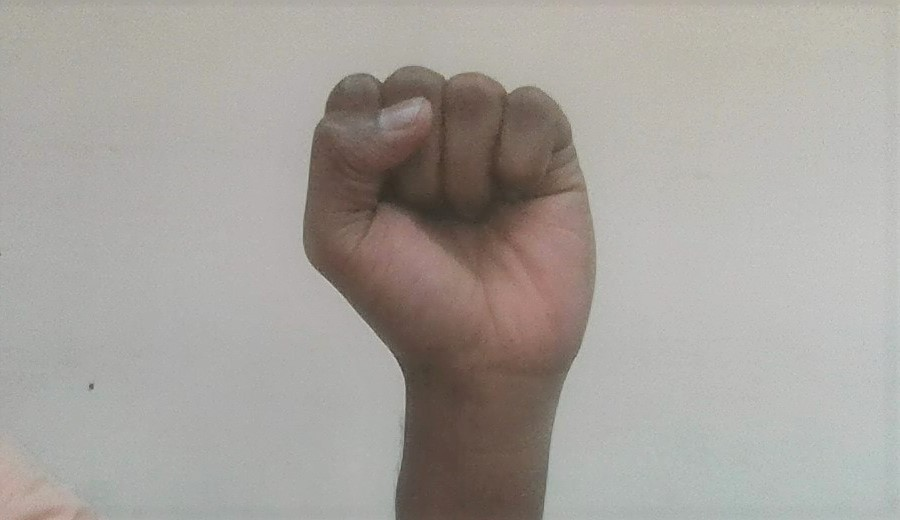

1/1 [==============================] - 1s 652ms/step
Floor number: 5


In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow
# Load the trained model
model = load_model('/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5')

# Define the function to preprocess the image before feeding it to the model
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    img = img.reshape(1, 128, 128, 1)
    img = img.astype('float32')
    img /= 255
    return img

# Define the function to predict the floor number based on the image
def predict_floor_number(img):
    img = preprocess_image(img)
    pred = model.predict(img)
    floor_number = np.argmax(pred)
    return floor_number

# Open the video file
frame = cv2.imread('/content/drive/MyDrive/Major_Project/fingers/model2/zero (3).jpg')

# while True:
#     # Read a frame from the video file
#     ret, frame = cap.read()
#     if ret:
        # Display the frame
cv2_imshow(frame)
        
        # Predict the floor number based on the current frame
floor_number = predict_floor_number(frame)
print('Floor number:', floor_number)
        
        # # Check for the 'q' key press to exit the loop
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

# Release the video file and close all windows
# cap.release()
cv2.destroyAllWindows()


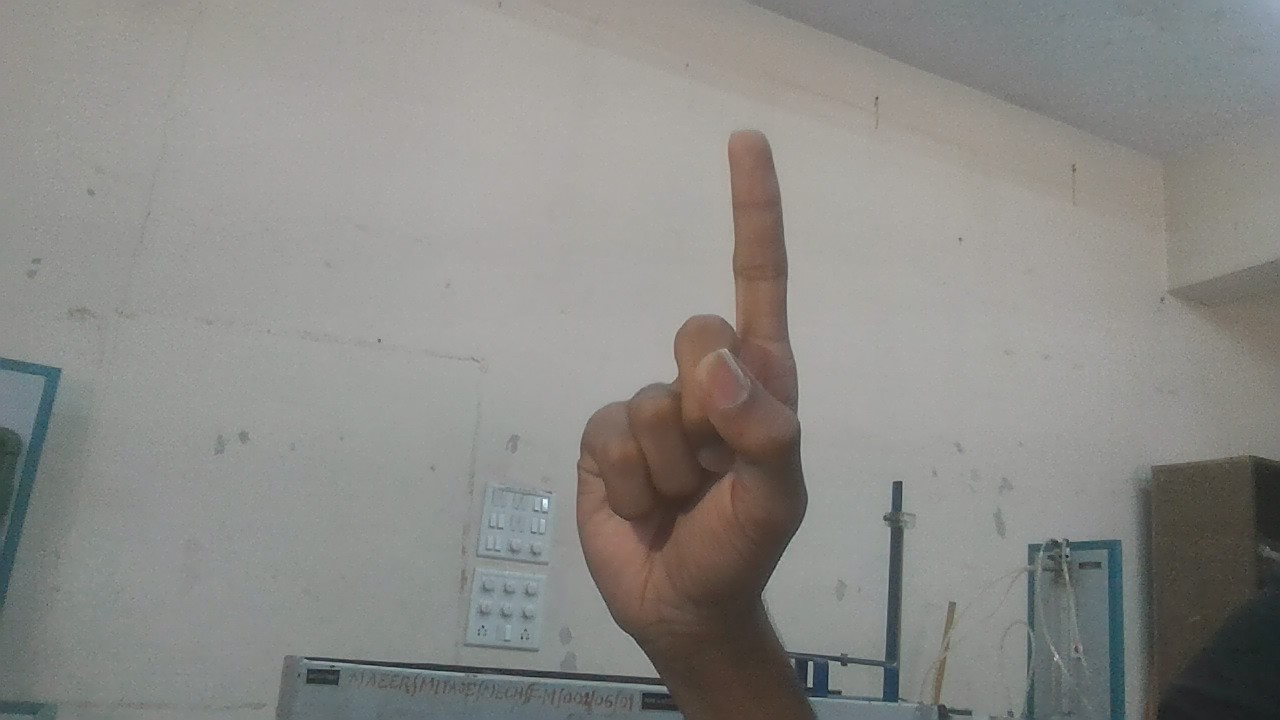

1/1 [==============================] - 0s 303ms/step
Floor number: 0


In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow
# Load the trained model
model = load_model('/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5')

# Define the function to preprocess the image before feeding it to the model
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    img = img.reshape(1, 128, 128, 1)
    img = img.astype('float32')
    img /= 255
    return img

# Define the function to predict the floor number based on the image
def predict_floor_number(img):
    img = preprocess_image(img)
    pred = model.predict(img)
    floor_number = np.argmax(pred)
    return floor_number

# Open the video file
frame = cv2.imread('/content/drive/MyDrive/Major_Project/fingers/model2/one.jpg')

# while True:
#     # Read a frame from the video file
#     ret, frame = cap.read()
#     if ret:
        # Display the frame
cv2_imshow(frame)
        
        # Predict the floor number based on the current frame
floor_number = predict_floor_number(frame)
print('Floor number:', floor_number)
        
        # # Check for the 'q' key press to exit the loop
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

# Release the video file and close all windows
# cap.release()
cv2.destroyAllWindows()


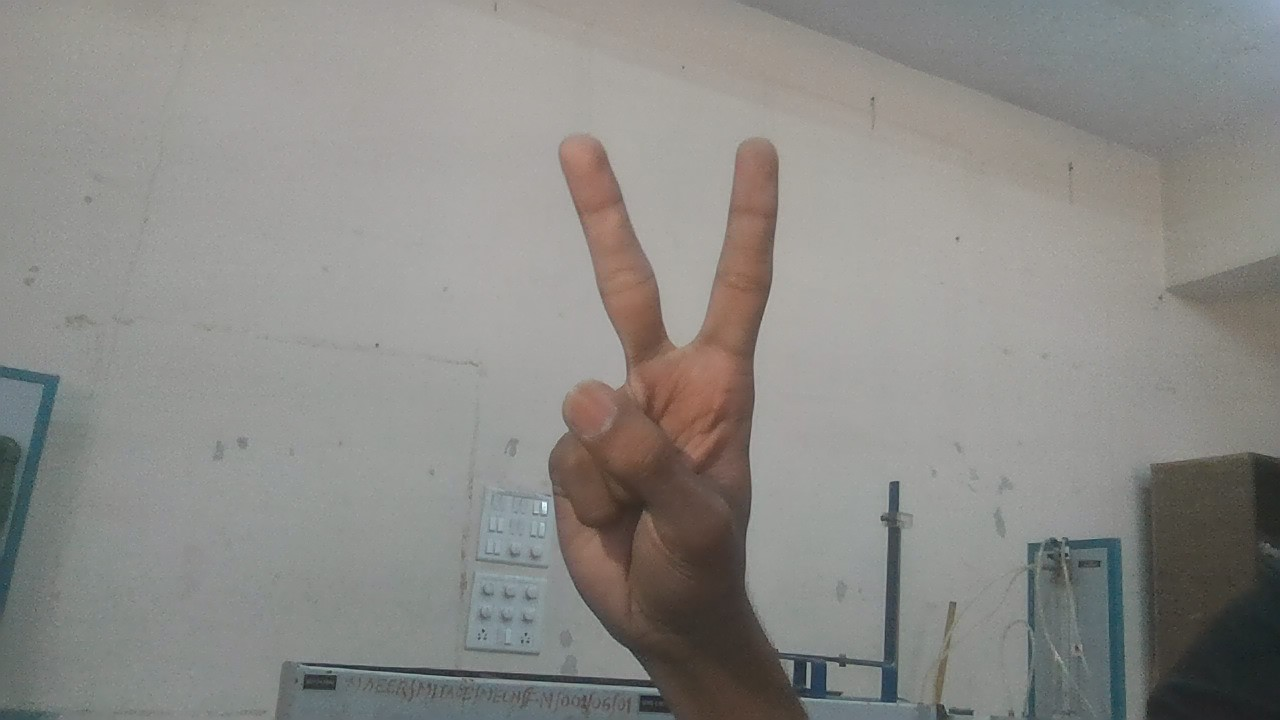

1/1 [==============================] - 0s 268ms/step
Floor number: 0


In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow
# Load the trained model
model = load_model('/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5')

# Define the function to preprocess the image before feeding it to the model
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    img = img.reshape(1, 128, 128, 1)
    img = img.astype('float32')
    img /= 255
    return img

# Define the function to predict the floor number based on the image
def predict_floor_number(img):
    img = preprocess_image(img)
    pred = model.predict(img)
    floor_number = np.argmax(pred)
    return floor_number

# Open the video file
frame = cv2.imread('/content/drive/MyDrive/Major_Project/fingers/model2/two.jpg')

# while True:
#     # Read a frame from the video file
#     ret, frame = cap.read()
#     if ret:
        # Display the frame
cv2_imshow(frame)
        
        # Predict the floor number based on the current frame
floor_number = predict_floor_number(frame)
print('Floor number:', floor_number)
        
        # # Check for the 'q' key press to exit the loop
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

# Release the video file and close all windows
# cap.release()
cv2.destroyAllWindows()


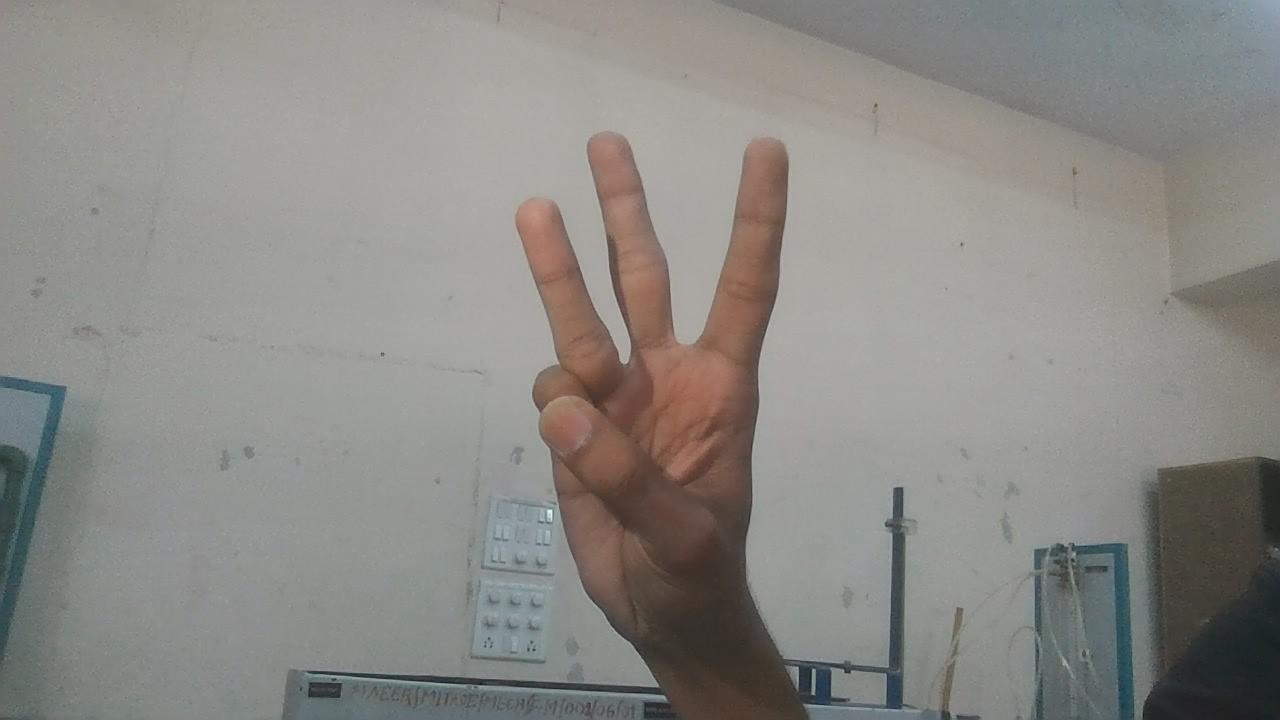

1/1 [==============================] - 0s 260ms/step
Floor number: 0


In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow
# Load the trained model
model = load_model('/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5')

# Define the function to preprocess the image before feeding it to the model
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    img = img.reshape(1, 128, 128, 1)
    img = img.astype('float32')
    img /= 255
    return img

# Define the function to predict the floor number based on the image
def predict_floor_number(img):
    img = preprocess_image(img)
    pred = model.predict(img)
    floor_number = np.argmax(pred)
    return floor_number

# Open the video file
frame = cv2.imread('/content/drive/MyDrive/Major_Project/fingers/model2/three.jpg')

# while True:
#     # Read a frame from the video file
#     ret, frame = cap.read()
#     if ret:
        # Display the frame
cv2_imshow(frame)
        
        # Predict the floor number based on the current frame
floor_number = predict_floor_number(frame)
print('Floor number:', floor_number)
        
        # # Check for the 'q' key press to exit the loop
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

# Release the video file and close all windows
# cap.release()
cv2.destroyAllWindows()


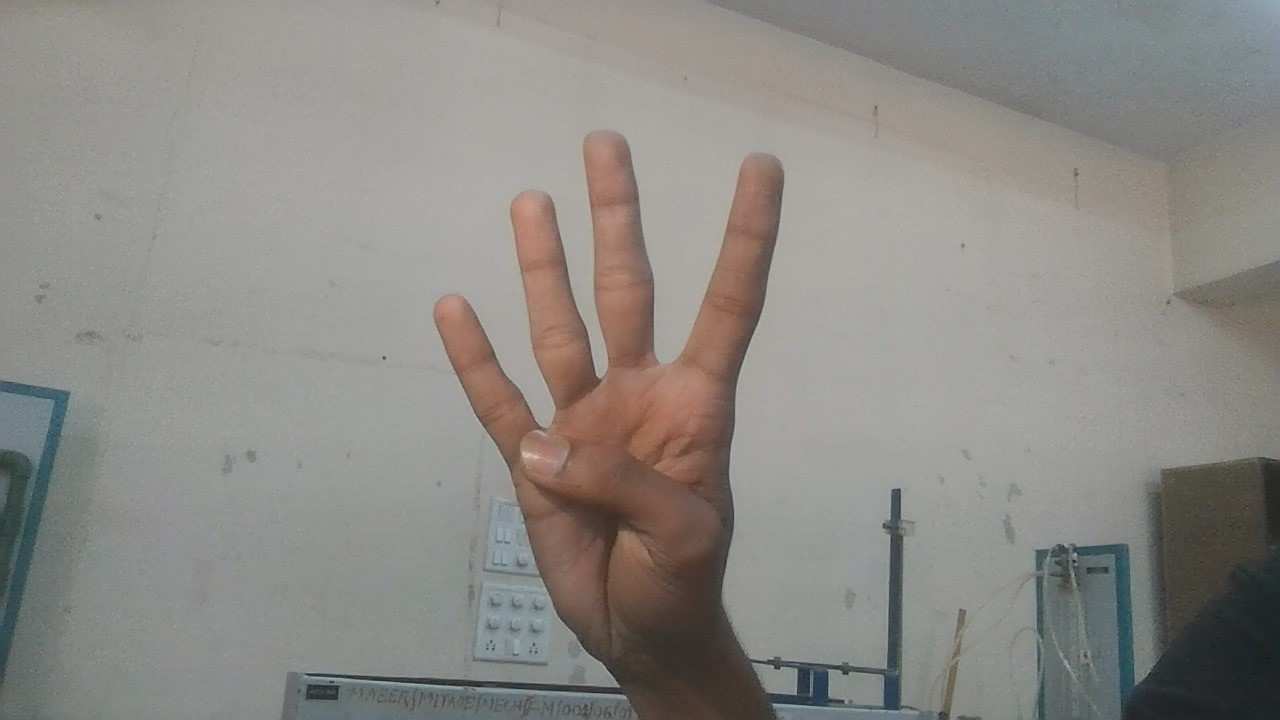

1/1 [==============================] - 0s 333ms/step
Floor number: 0


In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow
# Load the trained model
model = load_model('/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5')

# Define the function to preprocess the image before feeding it to the model
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    img = img.reshape(1, 128, 128, 1)
    img = img.astype('float32')
    img /= 255
    return img

# Define the function to predict the floor number based on the image
def predict_floor_number(img):
    img = preprocess_image(img)
    pred = model.predict(img)
    floor_number = np.argmax(pred)
    return floor_number

# Open the video file
frame = cv2.imread('/content/drive/MyDrive/Major_Project/fingers/model2/four.jpg')

# while True:
#     # Read a frame from the video file
#     ret, frame = cap.read()
#     if ret:
        # Display the frame
cv2_imshow(frame)
        
        # Predict the floor number based on the current frame
floor_number = predict_floor_number(frame)
print('Floor number:', floor_number)
        
        # # Check for the 'q' key press to exit the loop
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

# Release the video file and close all windows
# cap.release()
cv2.destroyAllWindows()


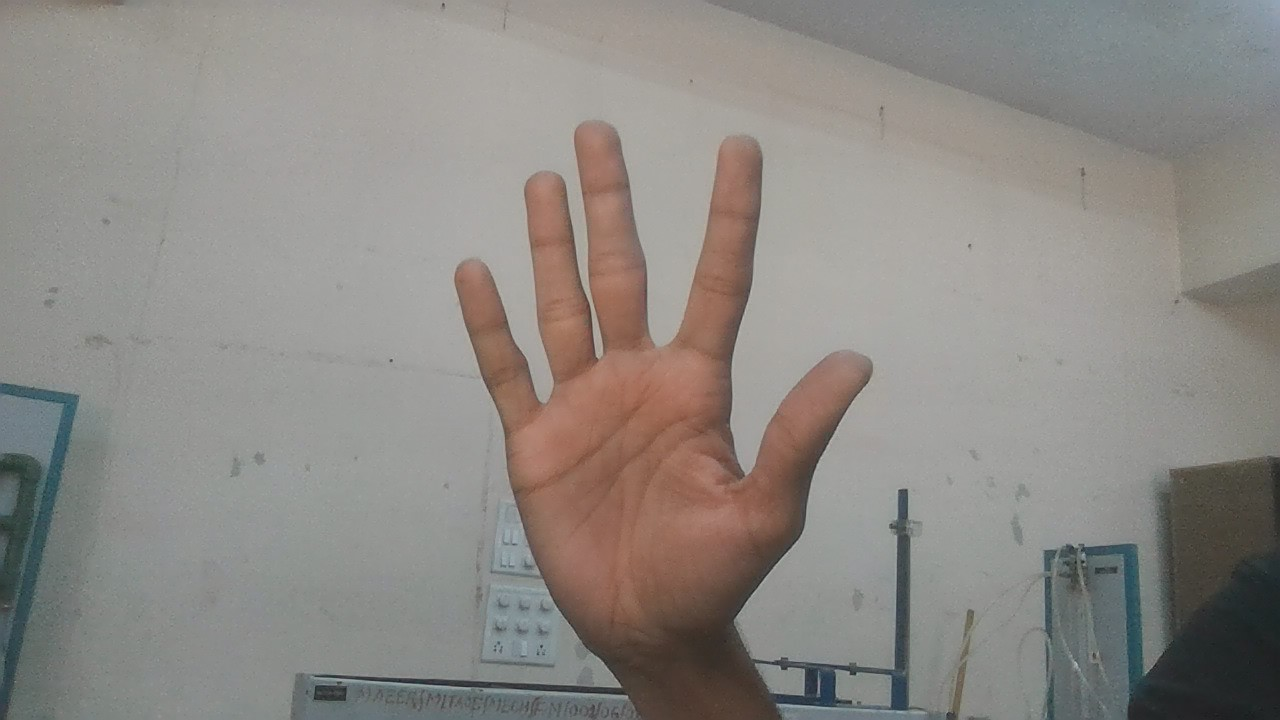

1/1 [==============================] - 0s 352ms/step
Floor number: 0


In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow
# Load the trained model
model = load_model('/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5')

# Define the function to preprocess the image before feeding it to the model
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    img = img.reshape(1, 128, 128, 1)
    img = img.astype('float32')
    img /= 255
    return img

# Define the function to predict the floor number based on the image
def predict_floor_number(img):
    img = preprocess_image(img)
    pred = model.predict(img)
    floor_number = np.argmax(pred)
    return floor_number

# Open the video file
frame = cv2.imread('/content/drive/MyDrive/Major_Project/fingers/model2/five.jpg')

# while True:
#     # Read a frame from the video file
#     ret, frame = cap.read()
#     if ret:
        # Display the frame
cv2_imshow(frame)
        
        # Predict the floor number based on the current frame
floor_number = predict_floor_number(frame)
print('Floor number:', floor_number)
        
        # # Check for the 'q' key press to exit the loop
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

# Release the video file and close all windows
# cap.release()
cv2.destroyAllWindows()


In [ ]:
# import cv2
# import numpy as np
# from keras.models import load_model
# from google.colab.patches import cv2_imshow
# # Load the trained model
# model = load_model('/content/drive/MyDrive/Major_Project/fingers/model2/handmodel_fingers_model2.h5')

# # Define the function to preprocess the image before feeding it to the model
# def preprocess_image(img):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = cv2.resize(img, (128, 128))
#     img = img.reshape(1, 128, 128, 1)
#     img = img.astype('float32')
#     img /= 255
#     return img

# # Define the function to predict the floor number based on the image
# def predict_floor_number(img):
#     img = preprocess_image(img)
#     pred = model.predict(img)
#     floor_number = np.argmax(pred)
#     return floor_number

# # Open the video file
# cap = cv2.VideoCapture('/content/drive/MyDrive/Major_Project/fingers/model2/four.mp4')

# while True:
#     # Read a frame from the video file
#     ret, frame = cap.read()
#     if ret:
#         # Display the frame
#         cv2_imshow(frame)
        
#         # Predict the floor number based on the current frame
#         floor_number = predict_floor_number(frame)
#         print('Floor number:', floor_number)
        
#         # Check for the 'q' key press to exit the loop
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

# # Release the video file and close all windows
# cap.release()
# cv2.destroyAllWindows()
